In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

conn = sqlite3.connect("../db/baltasar.db")
def sql(query):
    return pd.read_sql_query(query, conn)

In [ ]:
sql('''SELECT * FROM Transfer WHERE
    Transfer.`from` in (SELECT address FROM Address WHERE isCappReceiver = 1 OR isDepositAddress = 1 OR isCappStorage = 1 OR isCappOther = 1)
    and
    Transfer.`to` in (SELECT address FROM Address WHERE isCappReceiver = 1 OR isCappSender = 1 OR isCappStorage = 1 OR isCappOther = 1)''')

In [29]:
sql('''SELECT count(*) FROM potentialICOs''')

,count(*)
0,5876


In [20]:
sql('''CREATE TABLE potentialICOs AS
	SELECT t.`token` as token, t.`from` as address, sum(amountInUSDCurrent) as originalAmount, min(blocknumber) as blocknumber, isOriginAddress
			FROM 
				Transfer t
				INNER JOIN
				Address a
				ON t.`from` = a.address
				NATURAL JOIN
				AddressMetadata m
			WHERE m.distinctInDegree < 0.2 * m.distinctOutDegree
			GROUP BY t.token, t.`from`
			HAVING count(*) > 100 and originalAmount > 100;''')

TypeError: 'NoneType' object is not iterable

In [ ]:
sql('''SELECT 
			t.`to`, count(DISTINCT sender.address), receiverMetadata.distinctInDegree
		FROM
            Address receiver
            INNER JOIN
			AddressMetadata receiverMetadata
			LEFT OUTER JOIN 
			Transfer t
			LEFT OUTER JOIN
			Address sender
			ON sender.address = t.`from` AND sender.isDepositAddress=1
				and receiverMetadata.address = t.`to`
                and receiver.address = receiverMetadata.address
                and receiver.isCappReceiver = 1
		GROUP BY t.`to`
		HAVING 
			count(DISTINCT sender.address) < 100 and 
			count(DISTINCT sender.address) < 0.25 * receiverMetadata.distinctInDegree
''')

In [13]:
sql('''UPDATE Address
SET isDepositAddress = 1
WHERE Address.address in
	(SELECT 
		a.address
	FROM
		Address a
		INNER JOIN
		Transfer t
		INNER JOIN
		Address receiver
		ON a.address = t.`from` and t.`to`=receiver.address
	WHERE
		a.isDepositAddress = 0
	GROUP BY a.address
	HAVING 
		count(*) = sum(receiver.isCappReceiver) AND
		(count(*) < 10 OR SUM(t.emptiedAccount) > 0.25 * count(*)))
''')

TypeError: 'NoneType' object is not iterable

In [14]:
sql('''
SELECT rcv, SUM(isDepositAddress) / (1.0*count(*)) as matchedPercentage, sum(behavedLikeDepositAddress) as behavedLikeDepositAddresses, sum(isDepositAddress) as numDepositAddresses, count(*) as distinctIndegree FROM
    (SELECT distinct sender.address as snd, receiver.address as rcv, sender.isDepositAddress, senderM.behavedLikeDepositAddress
        from address receiver INNER JOIN
            address sender INNER JOIN
            AddressMetadata senderM INNER JOIN
            transfer t
            ON receiver.address = t.`to` and sender.address = t.`from` and receiver.isCappReceiver = 1 and sender.address = senderM.address) a
group by rcv
order by matchedPercentage
''')

,rcv,matchedPercentage,behavedLikeDepositAddresses,numDepositAddresses,distinctIndegree
0,0x1552730a652a567c8eb94e162e25a832dd64f5a4,0.310789,193,193,621
1,0xec83d198913f9d9fefa3ef25945312f4389ce7ce,0.345036,230,285,826
2,0x25649fa12925864b6f04bbdf6b64294a2f63be8f,0.349544,115,115,329
3,0xa70cdb332ecb5eb29ebe42ab3efd4b03c63ece0c,0.379359,691,805,2122
4,0x3521c7228dc767d92d160444d31ef5e0e2638888,0.419410,5223,5428,12942
5,0x8eeaddba91704d51cf69935928ed9ae100ae4cda,0.423358,380,522,1233
6,0x581e0be71b101bb716d66415c0ac4a9c6bca9bf5,0.438596,100,100,228
7,0xc20ef821b07c1e446a90384509d0fc91c5d0bc12,0.447141,2329,2377,5316
8,0xfaa68ee0df6bc5e6a2174e7df2ec252931302e60,0.448518,994,1407,3137
9,0x306d5e8af6aeb73359dcc5e22c894e2588f76ffb,0.479927,165,263,548


In [7]:
ans = sql('''SELECT distinctDegree, count(*) FROM AddressMetadata GROUP BY distinctDegree''')

DatabaseError: Execution failed on sql 'SELECT distinctDegree, count(*) FROM AddressMetadata GROUP BY distinctDegree': database is locked

In [11]:
data = pd.read_csv('../expOutput_all.csv')


def identify_pareto(data):
    data['numalsePositivesInverted'] = -data['numFalsePositives']
    scores = data[['numDepositAddresses', 'numalsePositivesInverted']].values
    data = data.drop(columns="numalsePositivesInverted")
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    data['pareto'] = pareto_front
    return data

data = identify_pareto(data)

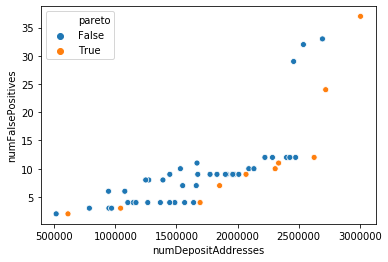

In [13]:
sns.scatterplot(data=data, x='numDepositAddresses', y='numFalsePositives', hue='pareto')

In [14]:
data

,numBlocks,percentage,numCappReceivers,numDepositAddresses,numFalsePositives,pareto
0,17280,0.30,1025,1972719,9,False
1,17280,0.35,1006,1954812,9,False
2,17280,0.40,985,1661912,7,False
3,17280,0.45,959,1550836,7,False
4,8640,0.15,972,2285215,12,False
5,25920,0.25,1165,2307434,10,True
6,25920,0.35,1101,2009747,9,False
7,25920,0.50,1028,1566884,4,False
8,34560,0.25,1242,2399968,12,False
9,34560,0.35,1178,2091599,10,False


In [17]:
sql('''SELECT 
    (SELECT count(*) FROM address where isCappReceiver = 1) as numCappReceivers,
    (SELECT count(*) FROM address where isDepositAddress = 1) as numDepositAddresses,
    (SELECT count(*) FROM address where isDepositAddress = 1 and isExchange = 0 and name is not null) as numFalsePositives,
    (SELECT group_concat(address,';') FROM address where isDepositAddress = 1 and isExchange = 0 and name is not null) as falsePositives''')

,numCappReceivers,numDepositAddresses,numFalsePositives,falsePositives
0,600,1043151,3,0xbbc79794599b19274850492394004087cbf89710;0x4...
